# Transformer

| <img src="image/transformer_en.svg"> | <img src="image/transformer.svg"> | <img src="image/transformer_cn.svg"> | 
| --- | --- | --- |

In [1]:
import math
import pandas as pd
import torch
from torch import nn

## Positionwise Feed-Forward Networks

In [2]:
class PositionWiseFFN(nn.Module):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        """ 
        Parameters
        ----------
        @param X : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        @return out : torch.Tensor
            Shape (batch_size, seq_len, ffn_num_outputs)
        """
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

/opt/data/private/linkdom/miniconda3/miniconda3/envs/conformer/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[-0.2358,  0.2526, -0.1030, -0.3341, -0.3947, -0.0368, -0.0482,  0.7117],
        [-0.2358,  0.2526, -0.1030, -0.3341, -0.3947, -0.0368, -0.0482,  0.7117],
        [-0.2358,  0.2526, -0.1030, -0.3341, -0.3947, -0.0368, -0.0482,  0.7117]],
       grad_fn=<SelectBackward0>)

## Residual Connection and Layer Normalization

| Batch Norm                                                   | Layer Norm                                                   | Instance Norm                                                |
| ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ |
| ![Batch](image/batch-norm.png) | ![Layer](image/layer-norm.png) | ![Instance](image/instance-norm.png) |

- 上图显示的是$(N,C,H,W)$，其中把最后两个维度乘在了一起，就是$(N,C,H*W)$方便理解一点；
- 在我们的序列问题中，可以将其看成是$(N,C,T)$，其中$N$是`batch_size`，$C$是`hidden_dims`，$T$是`seq_len`；
- $(N,H*W,C)$ <-> $(N,T,C)$

In [4]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor(
    [[1, 2], [2, 3]], 
    dtype=torch.float32
)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape) # for num_hiddens

    def forward(self, X, Y):
        """
        Parameters
        ----------
        @param X : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        @param Y : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        @return out : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        """
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
add_norm(torch.ones(shape), torch.ones(shape)).shape == shape

True

## Encoder

In [7]:
from attention import MultiHeadAttention

class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(
            num_hiddens, num_heads,
            dropout, use_bias
        )
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        """
        Parameters
        ----------
        @param X : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        @param valid_lens : torch.Tensor
            Shape (batch_size, )
        @return out : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        """
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape == X.shape

/opt/data/private/linkdom/miniconda3/miniconda3/envs/conformer/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


True

In [9]:
from attention import PositionalEncoding

class TransformerEncoder(nn.Module):  #@save
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        """
        The Transformer encoder.
        
        Parameters
        ----------
        @param vocab_size : int
        @param num_hiddens : int
        @param ffn_num_hiddens : int
        @param num_heads : int
        @param num_blks : int
        @param dropout : float
        @param use_bias : bool
        """
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                "block"+str(i), 
                TransformerEncoderBlock(
                    num_hiddens, 
                    ffn_num_hiddens, 
                    num_heads, 
                    dropout, 
                    use_bias
                )
            )

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(
    vocab_size=200, 
    num_hiddens=24, 
    ffn_num_hiddens=48, 
    num_heads=8, 
    num_blks=2, 
    dropout=0.5
)
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape == (2, 100, 24)

True

## Decoder

In [11]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        """
        The i-th block in the Transformer decoder

        Parameters
        ----------
        @param num_hiddens : int
        @param ffn_num_hiddens : int
        @param num_heads : int
        @param dropout : float
        @param i : int
            The index of the block in the decoder
        """
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(
            num_hiddens, num_heads, dropout
        )
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(
            num_hiddens, num_heads, dropout
        )
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        """"
        Parameters
        ----------
        @param X : torch.Tensor
            Shape (batch_size, seq_len, num_hiddens)
        @param state : list
            the first element is the encoder output, 
            the second element is the encoder valid length, 
            The third element: decoding state (contains representations of
            outputs in the previous time step)
        """
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device
            ).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)

        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [12]:
decoder_blk = TransformerDecoderBlock(
    num_hiddens=24, 
    ffn_num_hiddens=48, 
    num_heads=8, 
    dropout=0.5, 
    i=0
)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape == X.shape

True

In [13]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        """
        The Transformer decoder.

        Parameters
        ----------
        @param vocab_size : int
        @param num_hiddens : int
        @param ffn_num_hiddens : int
        @param num_heads : int
        @param num_blks : int
        @param dropout : float
        """
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                "block"+str(i), 
                TransformerDecoderBlock(
                    num_hiddens, ffn_num_hiddens, 
                    num_heads, dropout, i
                )
            )
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        """
        Parameters
        ----------
        @param X : torch.Tensor
            Shape (batch_size, seq_len)
        @param state : list
            The first element: enc_outputs, 
            The second element: enc_valid_lens, 
            The third element: decoding state (contains representations of
            outputs in the previous time step)
        """
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [14]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## Train

loss 0.028, 7249.6 tokens/sec on cuda:0


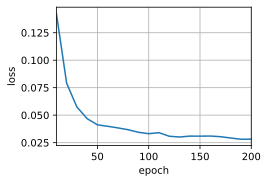

In [15]:
from d2l import torch as d2l
num_hiddens, num_blks, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab),
    num_hiddens, 
    ffn_num_hiddens, 
    num_heads,
    num_blks, 
    dropout
)
decoder = TransformerDecoder(
    len(tgt_vocab), 
    num_hiddens, 
    ffn_num_hiddens, 
    num_heads,
    num_blks, 
    dropout
)
transformer = EncoderDecoder(
    encoder, decoder
)
d2l.train_seq2seq(
    transformer, 
    train_iter, 
    lr, 
    num_epochs, 
    tgt_vocab, 
    device
)

In [16]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        transformer, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


## Encoder attention

In [17]:
enc_attention_weights = torch.cat(
    transformer.encoder.attention_weights, 0
).reshape(
    (num_blks, num_heads, -1, num_steps)
)
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

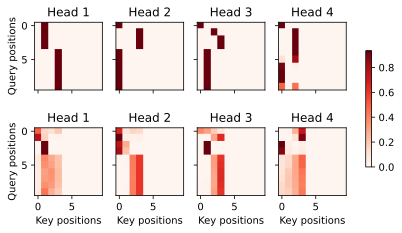

In [18]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), 
    xlabel='Key positions',
    ylabel='Query positions', 
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)

## Decoder attention

In [19]:
dec_attention_weights_2d = [
    head[0].tolist()
        for step in dec_attention_weight_seq
            for attn in step 
                for blk in attn 
                    for head in blk
]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values
)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_blks, num_heads, num_steps)
)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

### Self Attention

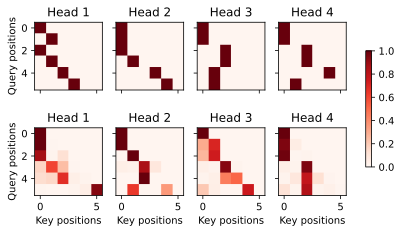

In [20]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], 
    figsize=(7, 3.5)
)

## Inter attention

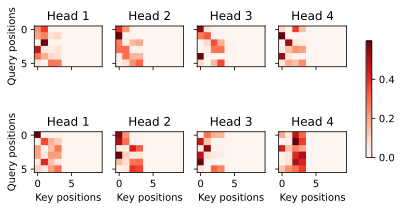

In [21]:
d2l.show_heatmaps(
    dec_inter_attention_weights,
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], 
    figsize=(7, 3.5)
)